In [0]:
import cv2
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from scipy.ndimage import zoom
import numpy as np
import math

image = cv2.imread('image.jpg', 0)

Set the max deviation from vertical in the radon transform:

In [0]:
max_angle = 45
angles = np.hstack([
    np.arange(0, max_angle),
    np.arange(180 - max_angle, 180)
])

In [0]:
projections = radon(image, theta=angles, circle=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Image dtype is not float. By default radon will assume you want to preserve the range of your image (preserve_range=True). In scikit-image 0.18 this behavior will change to preserve_range=False. To avoid this warning, explicitly specify the preserve_range parameter.
  """Entry point for launching an IPython kernel.


Currently just pick the peak, but may choose another points in the sinogram according to some another heuristic:

In [0]:
peak = np.unravel_index(projections.argmax(), projections.shape)
# The tomography rotation axis will lie at the pixel 
# index 'radon_image.shape[0] // 2' along the 0'th dimension of 'radon_image':
peak = (peak[0] - (projections.shape[0] // 2), peak[1]) 

*Find* the line equation (in the original image) of point in the sinogram.

In [0]:
def get_bias_slope(radon_point, image, angles):
    r = radon_point[0]
    theta = angles[radon_point[1]]
    slope = np.tan(np.deg2rad(theta - 90))
    center_i, center_j = image.shape[0] // 2, image.shape[1] // 2
    #shouldn't it be  r*np.cos(np.deg2rad(theta))
    shift_on_center_line = r / np.cos(np.deg2rad(theta))
    point = (
        center_i,
        shift_on_center_line + center_j
    )
    #isn't bias just point[0]. This formula looks like a line equation.
    bias = point[0] + point[1] * slope
    return bias, slope

bias, slope = get_bias_slope(peak, image, angles)


Find the intersection of the bounderies of image and a line:

In [0]:
#what is this function supposed to do
def intersection_points(bias, slope, image):
    x = np.arange(image.shape[1])
    # why is it minus slope
    y = - slope * x + bias
    in_image = (y > 0) & (y < image.shape[0])
    #aren't both x and y 1-d. How does 2d indexing work
    point1 = (y[in_image][0], x[in_image][0])
    #does -1 == 1 ? If so, why not write one. Are you expecting
    #there to be a second axis of variable length?
    point2 = (y[in_image][-1], x[in_image][-1])
    return point1, point2

point1, point2 = intersection_points(bias, slope, image)

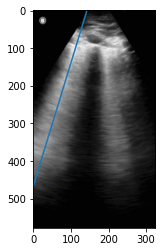

In [0]:
plt.imshow(image, cmap=plt.cm.Greys_r)
plt.plot([point1[1], point2[1]], [point1[0], point2[0]])